# Zadanie

Spośród zdjęć z folderu **Data**, proszę znaleźć 2 siostry mężczyzny ze zdjęcia **BASE.png**. 
## Wytyczne:
- Podczas wyszukiwania plików z wykorzystaniem modulu glob należy znaleźć znaleźć pliki zaczynające się na literę **C** z rozszerzeniem **.png**.
- Do wyznaczenia embeddingów można wykorzystać dowolną architekturę sztucznej sieci neuronowej z modułu **tensorflow.keras.applications**.
- Należy pamiętać, że przy zmianie sieci dane wejściwe muszą zostać odpowiednio przetworzone zgodnie z wymaganiami danej architektury zgodnie z [dokumentacją](https://www.tensorflow.org/api_docs/python/tf/keras/applications).
- Można wykorzystać inną metrykę niż euklidesowa - [dokumentacja](https://github.com/spotify/annoy).
- Przetworzone dane powinny zostać zapisane w bazie MongoDB.
- W sekcji **Wyniki** należy wyświetlić wybrane 2 siostry oraz odpowiadające im metryki.

### Ocena:
* Uzupełnenie kodu i uzyskanie wyników - 3.
* Przeprowadzenie analizy dla 2 różnych modeli z kombinacją 2 metryk (model1 - test dla 2 metryk, model2 - test dla 2 metryk) - 4.
* Przeprowadzenie analizy dla 3 różnych modeli z komibacją 3 metryk (model 1 - test dla 3 metryk, model2 - test dla 3 metryk i model 3 - test dla 3 metrytk) - 5.  
W każdym przypadku należy uzuepłnić sekcję wnioski o uzyskane wyniki.

# Wymagane biblioteki

In [1]:
!pip install tensorflow

In [36]:
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
import cv2
from IPython.display import Image
from annoy import AnnoyIndex
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications.efficientnet import preprocess_input


<div style="background: #d5e5ed; border-radius: 4px; padding: 10px;">Jeżeli jakaś bilbioteka nie jest zainstalowana to proszę ją zainstalować.</div>

# Połączenie z mongoDB

In [37]:

from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["102141"]
collection = db["embeddings"]


<div style="background: #d5e5ed; border-radius: 4px; padding: 10px;">Za "numer_indeksu" proszę wpisać odpowiedni numer indeksu.</div>

# Załadowanie wybranego modelu do tworzenia embeddingów

In [38]:
base_model = EfficientNetB6(weights="imagenet", include_top=False, pooling='avg', input_shape=(528, 528, 3))

165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 70s 0us/step 


<div style="background: #d5e5ed; border-radius: 4px; padding: 10px;">Za * proszę wstawić wybrany model z dokumentacji.</div>

In [41]:
model = Model(inputs=base_model.input, outputs=base_model.output)

# Przetwarzenie obrazów zgodnie z wymaganiami sieci

In [43]:
def preprocess_image(image_path, target_size=(528, 528)): # funkcja odpowiedzialna za przetwrzanie obrazów zgodnie z wymaganiami danego modelu.
    # image_path - określa ścieżką do danego obrazu, z target_size - docelowy rozmiar .
    # proszę skorzystać z funkcji load_image i w odpowiednio dostosować argument target_size.
    image = load_img(image_path, target_size=(528,528))
    # może się rónież przydać funkcja img_to_array.
    image = img_to_array(image)
    # należy pamiętać, że tensor wejściowy do modelu powinien być 4 wymiarowy (np.expand_dims).
    image = np.expand_dims(image,axis=0)
    # dla wybranego modelu należy, dane wejściowe muszą być odpowiednio przetworzone - ...preprocess_input(image).
    image = preprocess_input(image)
    return image # funkcja zwraca przetworzon obraz .

In [44]:
def extract_embedding(image_path): # funkcja odpowiedzialna za zwracanie embeddingów.
    # image-path ścieżka do obrazka.
    image = preprocess_image(image_path)
    embedding = model.predict(image)
    # obraz należy przetworzyć z wykorzystaniem obiektu model z metodą .predict.
    return embedding.flatten()

# Stworzenie embeddingu dla bazowe obrazu

In [47]:
base = extract_embedding('Data/BASE.png') # Embedding dla bazowego obrazu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


In [48]:
base

array([-0.17583175, -0.19460255, -0.1527647 , ..., -0.22917046,
       -0.07027475, -0.11196689], dtype=float32)

# Dodawanie dokumentow do bazy danych

In [49]:
def store_embedding(image_path, embedding): #funkcja odpowiedzialna za dodawanie embeddingów do bazy danych.
    # Do bazy danych należy dodać obiekt document z 2 kluczami: image_path - ścieżka do obrazu oraz embedding - wektor zwrócony z modelu. 
    # Należy pamiętać, że mongoDB nie obsługuje numpy, trzeba to przekonwertowac do listy.
    document = {"image_path":image_path, "embedding":extract_embedding(image_path).tolist()}
    collection.insert_one(document)

In [50]:
def add_to_database(pattern): # Funkcja odpowiedająca za dodawanie wyników do bazy.
    # Zmienna pattern określa ścieżkę do plików jak wzorzec.
    # W pierwszej kolejności proszę wykorzystać pętlę for in dla obiektu glob.glob z odpowiednim argumentem w postaci wzorca.
        for image_path in glob.glob('./Data/C*.png'):
            
            embedding = extract_embedding(image_path)
            store_embedding(image_path, embedding)
            print(f"Przetworzono i dodano do bazy: {image_path}")

W funkcji add_to_database należy wykorzystać moduł glob z ścieżką określoną przez wzorzec - [dokumentacja](https://docs.python.org/3/library/glob.html).

In [51]:
add_to_database('wzorzec')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
Przetworzono i dodano do bazy: ./Data\ComfyUI_00134_.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
Przetworzono i dodano do bazy: ./Data\ComfyUI_00135_.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
Przetworzono i dodano do bazy: ./Data\ComfyUI_00136_.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
Przetworzono i dodano do bazy: ./Data\ComfyUI_00137_.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Przetworzono i dodano do bazy: ./Data\ComfyUI_00138_.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
Przetworzono i dodano do bazy: ./Data\ComfyUI_00139_.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
Przetworzono i dodano do bazy: ./Data\ComfyUI_00140_.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━

# Pobiranie dokumentów z bazy danych

In [52]:
def load_embeddings(): # Funkcja odpowiedająca za pobieranie danych z bazy i przechwywanie ich w pamięci podręcznej.
    embeddings = [] # lista embeddingów z bazy.
    image_paths = [] # ściezki do obrazów.
    # Należy wykorzystać for in dla obiektu collection.find() a następnie dodać wyniki do uprzednio przedstawionych list.
    for document in collection.find():
        embeddings.append(document['embedding'])  # Pobieranie embeddingów
        image_paths.append(document['image_path'])  # Pobieranie ścieżek do obrazów
    return np.array(embeddings), image_paths
    

# Stworzenie indeksów za pomocą annoy

In [63]:
def build_annoy_index(embeddings, num_trees=10, metric ='hamming'): # funkcja odpowiedzialna za tworzenie indexów przez annoy.
    # embeddings - lista embeddingów.
    # num_trees - liczba drzew w lesi. Więcej oznacza większa precycję.
    dimension =len(embeddings[0])
    index = AnnoyIndex(dimension, metric=metric) # funkcja odpowiedzialna za budowanie indeksów. Zmienna dimension określa wymiar pojedynczego embeddingu,
    # a metric jest wybraną metryką zgodnie z dokumentacją.

    # W celu dodania indeksow embeddingów, należy po nich przeiterować i wykorzystać metodą index.add_item(i,e), gdzie i - określa indeks, a e - embedding.
    for i, embedding in enumerate(embeddings):
        index.add_item(i, embedding)
    index.build(num_trees) # metoda odpowiedzialna za budowanie drzewa.
    return index

In [64]:
embedings, paths = load_embeddings()

# Wyszukanie podobnych obrazów (top 5)

In [65]:
def find_similar_with_annoy(query_embedding, annoy_index, image_paths, top_k=5): # funkcja odpowiedzialna za wyszukiwanie.
    # query_embedding - wektor, według którego wyszukiwane będa podobieństwa.
    # annoy_index - funkcja build_annoy_index().
    # image_path - ścieżka do obrazków.
    # top_k - liczba najlepszych dopasować.
    indices = annoy_index.get_nns_by_vector(query_embedding, top_k, include_distances=True)
    results = [(image_paths[i], indices[1][j]) for j, i in enumerate(indices[0])]
    return results

In [66]:
annoy_index = build_annoy_index(embedings)

In [67]:
find_similar_with_annoy(base, annoy_index, paths)

[('./Data\\ComfyUI_00240_.png', 23.0),
 ('./Data\\ComfyUI_00155_.png', 26.0),
 ('./Data\\ComfyUI_00195_.png', 26.0),
 ('./Data\\ComfyUI_00187_.png', 27.0),
 ('./Data\\ComfyUI_00227_.png', 27.0)]

# Wyniki

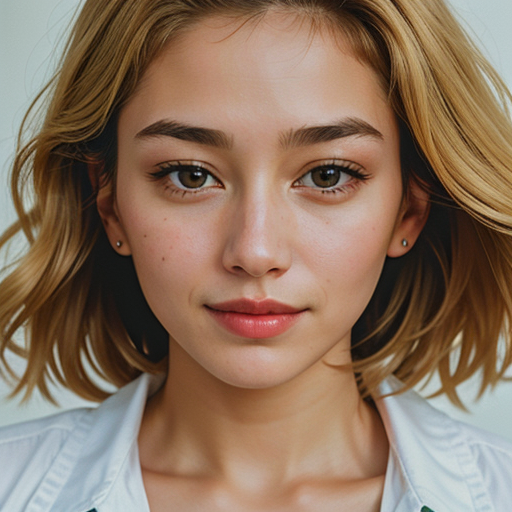

In [68]:
Image(filename='./Data\\ComfyUI_00240_.png')

# Wnioski

## Wnioski dla modelu  MobileNetV2(metryka Euklidesowa)
- ('./Data\\ComfyUI_00240_.png', 11.36115837097168),
- ('./Data\\ComfyUI_00162_.png', 15.048805236816406),
- ('./Data\\ComfyUI_00217_.png', 15.541938781738281),
- ('./Data\\ComfyUI_00181_.png', 15.788591384887695),
- ('./Data\\ComfyUI_00239_.png', 15.816734313964844)
#### Najbardziej pasującym zdjęciem było zdjęcie numer 240
## Wnioski dla modelu MobileNetV2(metryka Angular)
- ('./Data\\ComfyUI_00240_.png', 0.5025270581245422),
- ('./Data\\ComfyUI_00162_.png', 0.6623699069023132),
- ('./Data\\ComfyUI_00140_.png', 0.6799636483192444),
- ('./Data\\ComfyUI_00239_.png', 0.6895662546157837),
- ('./Data\\ComfyUI_00217_.png', 0.6984586715698242)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240 
## Wnioski dla modelu  MobileNetV2(metryka Hamming)
- ('./Data\\ComfyUI_00240_.png', 157.0),
- ('./Data\\ComfyUI_00162_.png', 204.0),
- ('./Data\\ComfyUI_00181_.png', 217.0),
- ('./Data\\ComfyUI_00140_.png', 220.0),
- ('./Data\\ComfyUI_00159_.png', 220.0)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240 
## Wnioski dla modelu DenseNet121(metryka Euklidesowa)
- ('./Data\\ComfyUI_00240_.png', 12.70197582244873),
- ('./Data\\ComfyUI_00236_.png', 13.332326889038086),
- ('./Data\\ComfyUI_00223_.png', 13.666252136230469),
- ('./Data\\ComfyUI_00225_.png', 13.681021690368652),
- ('./Data\\ComfyUI_00161_.png', 14.078516960144043)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240
## Wnioski dla modelu DenseNet121(metryka Angular)
- ('./Data\\ComfyUI_00240_.png', 0.5211948752403259),
- ('./Data\\ComfyUI_00236_.png', 0.5665968656539917),
- ('./Data\\ComfyUI_00239_.png', 0.5765751600265503),
- ('./Data\\ComfyUI_00161_.png', 0.5818867087364197),
- ('./Data\\ComfyUI_00181_.png', 0.5857800841331482)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240
## Wnioski dla modelu DenseNet121(metryka Hamming)
- ('./Data\\ComfyUI_00240_.png', 95.0),
- ('./Data\\ComfyUI_00165_.png', 111.0),
- ('./Data\\ComfyUI_00134_.png', 112.0),
- ('./Data\\ComfyUI_00223_.png', 117.0),
- ('./Data\\ComfyUI_00135_.png', 119.0)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240
## Wnioski dla modelu  EfficientNetB6 (metryka Euklidesowa)
- ('./Data\\ComfyUI_00240_.png', 4.264638423919678),
- ('./Data\\ComfyUI_00228_.png', 6.763221740722656),
- ('./Data\\ComfyUI_00239_.png', 6.992532253265381),
- ('./Data\\ComfyUI_00141_.png', 7.073333263397217),
- ('./Data\\ComfyUI_00233_.png', 7.121638298034668)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240
## Wnioski dla modelu  EfficientNetB6 (metryka Angular)
- ('./Data\\ComfyUI_00240_.png', 0.5657229423522949),
- ('./Data\\ComfyUI_00228_.png', 0.8644982576370239),
- ('./Data\\ComfyUI_00239_.png', 0.9030300974845886),
- ('./Data\\ComfyUI_00233_.png', 0.929977536201477),
- ('./Data\\ComfyUI_00141_.png', 0.941122829914093)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240
## Wnioski dla modelu  EfficientNetB6 (metryka Hamming)
- ('./Data\\ComfyUI_00240_.png', 23.0),
- ('./Data\\ComfyUI_00155_.png', 26.0),
- ('./Data\\ComfyUI_00195_.png', 26.0),
- ('./Data\\ComfyUI_00187_.png', 27.0),
- ('./Data\\ComfyUI_00227_.png', 27.0)
#### Najbardziej pasującym zdjęciem było zdjęcia numer 240

### Każdy z modeli wskazał, że najlepiej pasującym zdjęciem do bazowego jest zdjęcie 240

